In [1]:
!pip install underthesea emoji imblearn gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 24.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.6/978.6 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 33.0 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


## 1. Chuẩn bị và khám phá dữ liệu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import unicodedata
import re
import emoji
import os
import joblib
import requests
from underthesea import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix

from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('/kaggle/input/reviews-thegioididong/reviews_combined_labeled.csv')
df.head()

,comment_clean,comment,auto_label,confidence,label_filtered,rating,source
0,"hình ảnh đẹp, sắc nét, âm thanh sống động, y m...","Hình ảnh đẹp, sắc nét, âm thanh sống động, y m...",POS,0.992932,POS,5,thegioididong
1,"màn hình sắc nét, âm thanh rõ, lắp ráp đơn giả...","Màn hình sắc nét, âm thanh rõ, lắp ráp đơn giả...",POS,0.992666,POS,5,thegioididong
2,"giao hàng nhanh, dễ lắp đặt, thao tác nhanh ch...","Giao hàng nhanh, dễ lắp đặt, thao tác nhanh ch...",POS,0.992441,POS,5,thegioididong
3,tivi nhiều chức năng to đẹp rất hợp lý,Tivi nhiều chức năng to đẹp rất hợp lý,POS,0.992869,POS,5,thegioididong
4,săn sale mua tv cho mẹ mình vì mua 1 cái trước...,Săn sale mua tv cho mẹ mình vì mua 1 cái trước...,POS,0.992942,POS,5,thegioididong


In [4]:
df.drop(columns=["comment_clean", "auto_label", "confidence", "source"], axis=1, inplace=True)
df.rename(columns={"label_filtered": "label"}, inplace=True)
df.head()

,comment,label,rating
0,"Hình ảnh đẹp, sắc nét, âm thanh sống động, y m...",POS,5
1,"Màn hình sắc nét, âm thanh rõ, lắp ráp đơn giả...",POS,5
2,"Giao hàng nhanh, dễ lắp đặt, thao tác nhanh ch...",POS,5
3,Tivi nhiều chức năng to đẹp rất hợp lý,POS,5
4,Săn sale mua tv cho mẹ mình vì mua 1 cái trước...,POS,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4699 entries, 0 to 4698
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  4699 non-null   object
 1   label    4699 non-null   object
 2   rating   4699 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 110.3+ KB


In [6]:
print(f"Số lượng giá trị thiếu trong mỗi cột: {df.isnull().sum()}")
print(f"\nSố lượng comment bị trùng lặp: {df['comment'].duplicated().sum()}")

Số lượng giá trị thiếu trong mỗi cột: comment    0
label      0
rating     0
dtype: int64

Số lượng comment bị trùng lặp: 1


<function matplotlib.pyplot.show(close=None, block=None)>

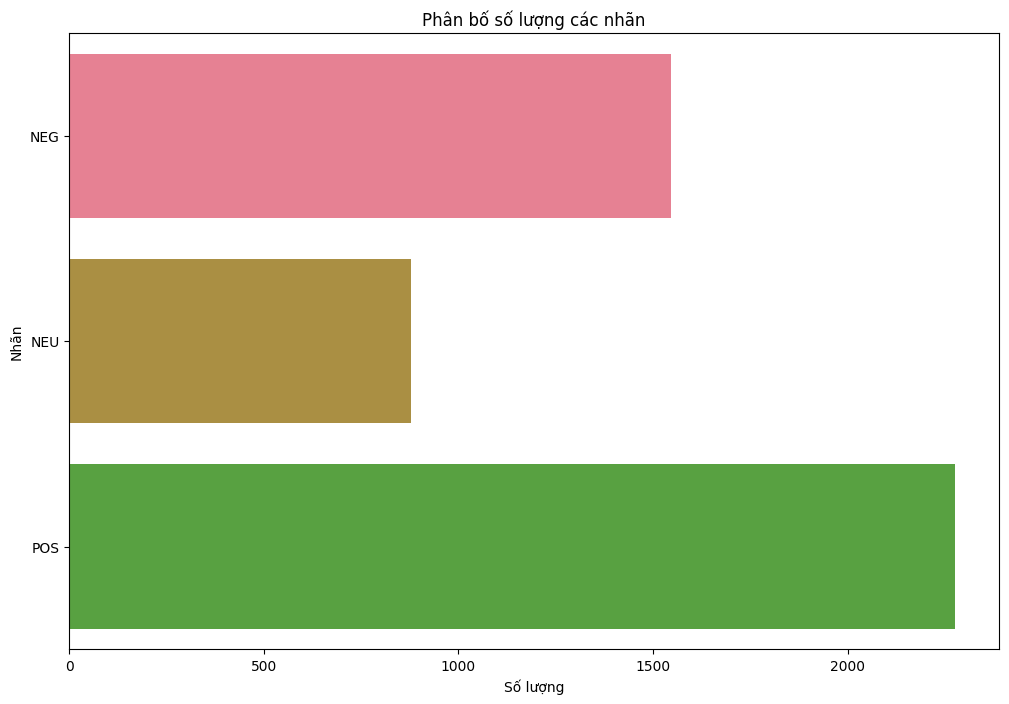

In [7]:
plt.style.use('default')
sns.set_palette('husl')

plt.figure(figsize=(12, 8))

sorted_label = sorted(df['label'].unique())

sns.countplot(
    y='label',
    data=df,
    order=sorted_label
)

plt.title('Phân bố số lượng các nhãn')
plt.xlabel('Số lượng')
plt.ylabel('Nhãn')
plt.show

## 2. Tiền xử lý dữ liệu

In [8]:
df.drop_duplicates(subset=['comment'], keep='first', inplace=True)
print(f"Số lượng bình luận còn lại sau khi lọc trùng: {len(df)}")

Số lượng bình luận còn lại sau khi lọc trùng: 4698


In [9]:
abbreviation_mapping = {
    'ko': 'không', 'k': 'không', 'kh': 'không', 'kg': 'không', 'hok': 'không', 'hong': 'không', 'kg': 'không',
    'dc': 'được', 'đc': 'được', 'dk': 'được', 'đk': 'được',
    'sp': 'sản phẩm',
    'nv': 'nhân viên',
    'dt': 'điện thoại', 'đt': 'điện thoại',
    'thks': 'cảm ơn', 'thanks': 'cảm ơn',
    'okla': 'oke', 'ok': 'oke',
    'chónk': 'chóng',
    'lém': 'lắm',
    'sài': 'xài',
    'mượt mà': 'mượt mà',
    'đẹp': 'đẹp',
    'chụp ảnh': 'chụp ảnh',
}

stopwords = set([
    "và", "nhưng", "hay", "hoặc", "rồi", "thì", "mà", "nếu", "với", "cho", "từ", "khi", "đến",
    "tôi", "bạn", "anh", "chị", "em", "họ", "chúng", "chúng_tôi", "chúng_ta", "nó",
    "này", "kia", "đó", "ấy", "cái", "chiếc", "nơi", "đâu", "đây", "kia", "kìa",
    "ở", "trên", "dưới", "trong", "ngoài", "vào", "ra", "lúc", "nơi", "này", "kia",
    "của", "bằng", "bởi", "do", "vì", "nên", "để",
    "à", "ừ", "ờ", "ơ", "dạ", "vâng", "nhé", "nhỉ", "cơ", "thôi", "mới", "đã", "sẽ", 
    "cũng", "đang", "vẫn", "hay_là", "chỉ", "nữa", "thật_ra", "thật_sự",
    "thứ", "lần", "cái", "chiếc"
])

punctuations = set([
    ",", "."
])

In [10]:
def clean_text(text):
    """Làm sạch văn bản"""
    
    # Chuẩn hóa Unicode
    text = unicodedata.normalize("NFC", text)

    # Chuyển về chữ thường
    text = text.lower().strip()
    
    # Loại bỏ nhiễu (htmls, urls và kí tự rỗng)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[\u200b\u200c\u200d\ufeff]', '', text)

    # Chuyển đổi emoji thành văn bản
    text = emoji.demojize(text, language='alias').replace(":", "").replace("_", " ")
    
    # Loại bỏ kí tự đặc biệt
    text = re.sub(r'[^\w\s,.?!]', '', text)

    # Chuẩn hóa từ lặp (ví dụ: ngonnn -> ngon)
    text = re.sub(r'(\w)\1+\b', r'\1', text)
    
    # Loại bỏ nhiều khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def map_abbreviations(text, mapping):
    """Hàm dùng để chuyển chữ viết tắt về dạng chuẩn"""
    
    sorted_keys = sorted(mapping.keys(), key=len, reverse=True)
    for key in sorted_keys:
        text = re.sub(r'\b' + re.escape(key) + r'\b', mapping[key], text)
    return text

def tokenize_and_remove_stopwords(text, stopwords_list):
    """Tokenize và loại bỏ stopwords"""
    
    text = word_tokenize(text, format="text")
    tokens = [t for t in text.split() if t not in stopwords_list and t not in punctuations]

    return ' '.join(tokens)
    
def preprocess_vietnamese_text(text):
    # Làm sạch cơ bản
    cleaned_text = clean_text(text)

    # Ánh xạ từ viết tắt
    mapped_text = map_abbreviations(cleaned_text, abbreviation_mapping)

    # Tách từ và loại bỏ stopwords
    final_text = tokenize_and_remove_stopwords(mapped_text, stopwords)
    
    return final_text

In [11]:
# Áp dụng tiền xử lý cho Dataframe
df['processed_comment'] = df['comment'].apply(preprocess_vietnamese_text)
list(df['processed_comment'][:5])

['hình_ảnh đẹp sắc_nét âm_thanh sống_động y mô_tả',
 'màn_hình sắc_nét âm_thanh rõ lắp_ráp đơn_giản shop giao hàng nhanh nhân_viên nhiệt_tình tư_vấn chăm_sóc không trước sau mua rất chuyên_nghiệp cảm_ơn shop',
 'giao hàng nhanh dễ lắp_đặt thao_tác nhanh_chóng nhân_viên hỗ_trợ nhiệt_tình',
 'tivi nhiều chức_năng to_đẹp rất hợp_lý',
 'săn sale mua tv mẹ mình mua 1 trước thấy ưng tv to xem siêu nha']

## 3. Trích chọn đặc trưng

In [12]:
sentiment_mapping = {
    'NEG': 0,
    'NEU': 1,
    'POS': 2
}
df['label'] = df['label'].map(sentiment_mapping)
df.head()

,comment,label,rating,processed_comment
0,"Hình ảnh đẹp, sắc nét, âm thanh sống động, y m...",2,5,hình_ảnh đẹp sắc_nét âm_thanh sống_động y mô_tả
1,"Màn hình sắc nét, âm thanh rõ, lắp ráp đơn giả...",2,5,màn_hình sắc_nét âm_thanh rõ lắp_ráp đơn_giản ...
2,"Giao hàng nhanh, dễ lắp đặt, thao tác nhanh ch...",2,5,giao hàng nhanh dễ lắp_đặt thao_tác nhanh_chón...
3,Tivi nhiều chức năng to đẹp rất hợp lý,2,5,tivi nhiều chức_năng to_đẹp rất hợp_lý
4,Săn sale mua tv cho mẹ mình vì mua 1 cái trước...,2,5,săn sale mua tv mẹ mình mua 1 trước thấy ưng t...


In [13]:
# Dữ liệu đầu vào
X = df['processed_comment']
y = df['label']

# Chia dữ liệu
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, stratify=y, random_state=42
)

print(f"Kích thước tập train: {len(X_train_text)} mẫu")
print(f"Kích thước tập test: {len(X_test_text)} mẫu")

Kích thước tập train: 3993 mẫu
Kích thước tập test: 705 mẫu


In [14]:
print("\nĐang trích chọn đặc trưng BoW...")
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)
print(f"Kích thước ma trận BoW tập train: {X_train_bow.shape}")

print("\nĐang trích chọn đặc trưng TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
print(f"Kích thước ma trận TF-IDF tập train: {X_train_tfidf.shape}")


Đang trích chọn đặc trưng BoW...
Kích thước ma trận BoW tập train: (3993, 5000)

Đang trích chọn đặc trưng TF-IDF...
Kích thước ma trận TF-IDF tập train: (3993, 5000)


In [15]:
"""Áp dụng SMOTE để xử lý imbalanced data"""
min_class_count = y_train.value_counts().min()
k_neighbors = min(5, min_class_count - 1) if min_class_count > 1 else 1

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

# Cân bằng tập train cho BoW
print(f"Số lượng mẫu train (BoW) trước khi SMOTE: {X_train_bow.shape[0]}")
X_train_bow_resampled, y_train_bow_resampled = smote.fit_resample(X_train_bow, y_train)
print(f"Số lượng mẫu train (BoW) sau khi SMOTE: {X_train_bow_resampled.shape[0]}")

# Cân bằng tập train cho TF-IDF
print(f"\nSố lượng mẫu train (TF-IDF) trước khi SMOTE: {X_train_tfidf.shape[0]}")
X_train_tfidf_resampled, y_train_tfidf_resampled = smote.fit_resample(X_train_tfidf, y_train)
print(f"Số lượng mẫu train (TF-IDF) sau khi SMOTE: {X_train_tfidf_resampled.shape[0]}")

Số lượng mẫu train (BoW) trước khi SMOTE: 3993
Số lượng mẫu train (BoW) sau khi SMOTE: 5799

Số lượng mẫu train (TF-IDF) trước khi SMOTE: 3993
Số lượng mẫu train (TF-IDF) sau khi SMOTE: 5799


## 4. Huấn luyện và đánh giá mô hình

In [19]:
datasets = {
    "BoW": (X_train_bow_resampled, y_train_bow_resampled, X_test_bow),
    "TF-IDF": (X_train_tfidf_resampled, y_train_tfidf_resampled, X_test_tfidf)
}

classifiers = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', C=0.9, probability=True, random_state=42)
}

In [20]:
# Tạo thư mục lưu trữ model và vectorizer
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
print(f"Các mô hình sẽ được lưu vào thư mục: '{model_dir}'")

# Lưu các Vectorizer
joblib.dump(bow_vectorizer, os.path.join(model_dir, 'bow_vectorizer.joblib'))
joblib.dump(tfidf_vectorizer, os.path.join(model_dir, 'tfidf_vectorizer.joblib'))

Các mô hình sẽ được lưu vào thư mục: 'models'


['models/tfidf_vectorizer.joblib']

Bắt đầu huấn luyện và đánh giá các mô hình...
----------------------------------------------------------------------
Đang xử lý: BoW + Naive Bayes
Đang xử lý: BoW + SVM
Đang xử lý: TF-IDF + Naive Bayes
Đang xử lý: TF-IDF + SVM


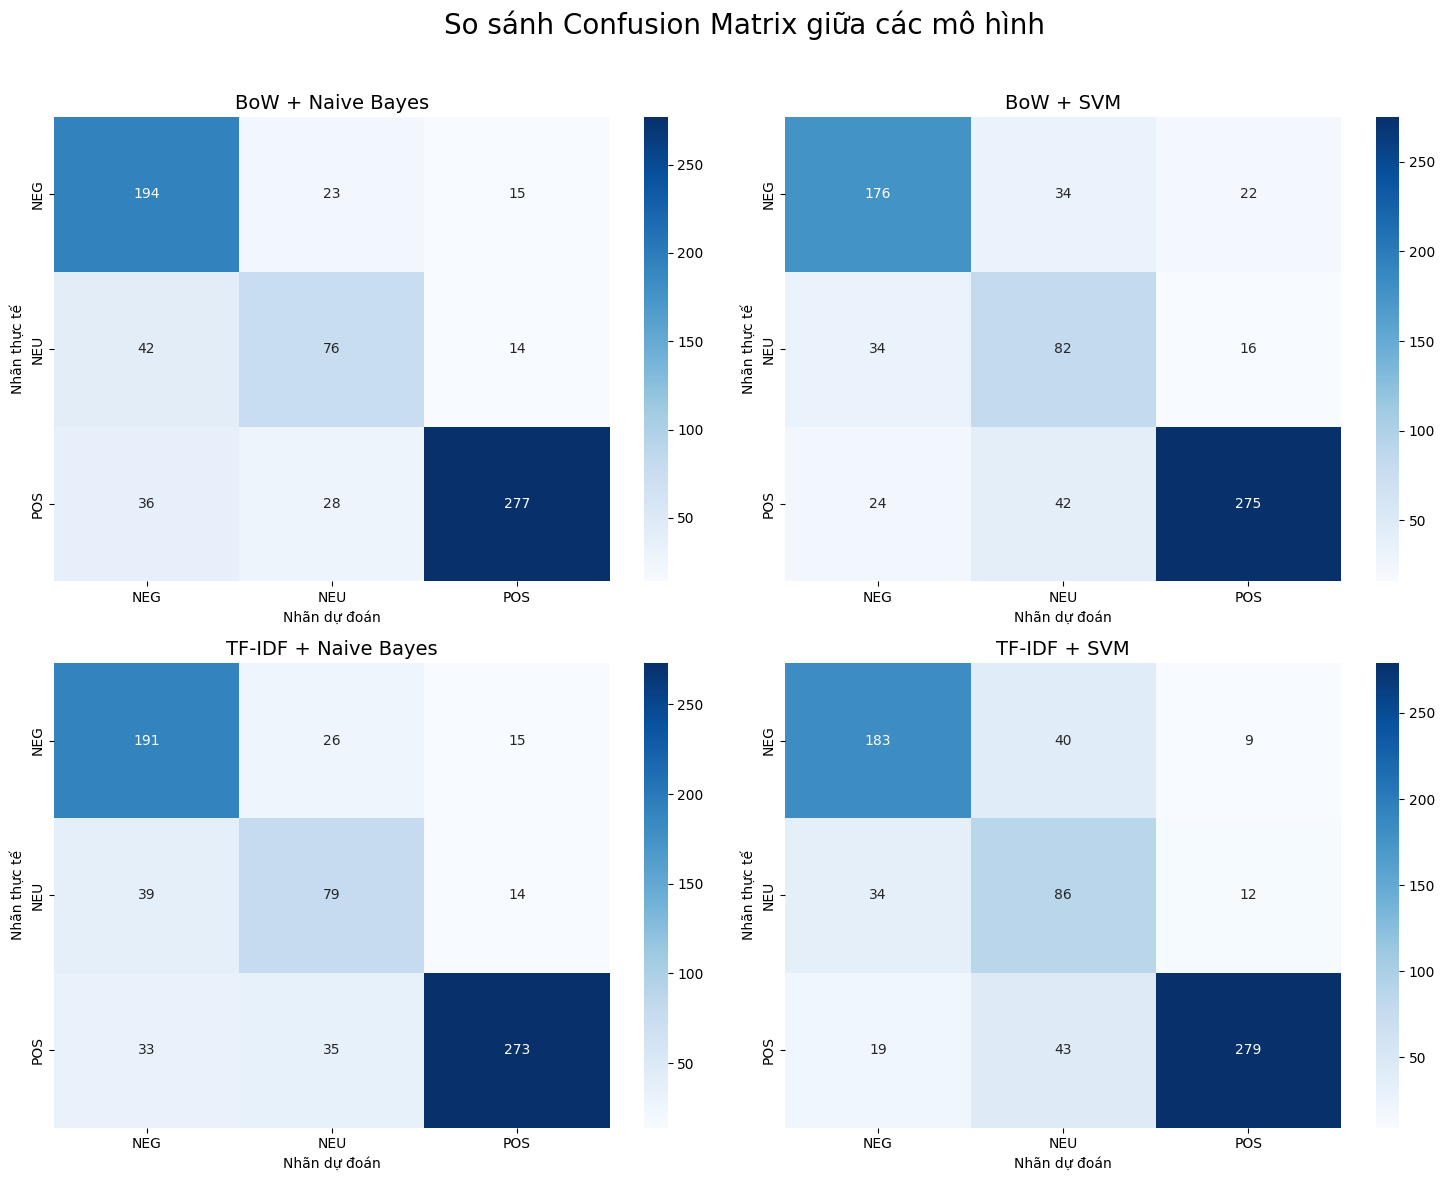


======================= BẢNG TỔNG HỢP KẾT QUẢ ========================
                  Model  Accuracy  Precision  Recall  F1-Score
0          TF-IDF + SVM    0.7773     0.8003  0.7773    0.7854
1     BoW + Naive Bayes    0.7759     0.7846  0.7759    0.7774
2  TF-IDF + Naive Bayes    0.7702     0.7819  0.7702    0.7734
3             BoW + SVM    0.7560     0.7696  0.7560    0.7612
\Mô hình tốt nhất (dựa trên F1-Score) là: TF-IDF + SVM với F1-Score = 0.7854


In [21]:
results = []
LABEL_NAMES = ['NEG', 'NEU', 'POS']
plot_data = []

print("Bắt đầu huấn luyện và đánh giá các mô hình...")
print("-" * 70)

for vec_name, (X_train, y_train_res, X_test) in datasets.items():
    for clf_name, classifier in classifiers.items():
        model_name = f"{vec_name} + {clf_name}"
        print(f"Đang xử lý: {model_name}")
        
        # Huấn luyện mô hình
        model = classifier
        model.fit(X_train, y_train_res)

        # Lưu model
        safe_filename = f"{vec_name.lower()}_{clf_name.replace(' ', '').lower()}_clf.joblib"
        joblib.dump(model, os.path.join(model_dir, safe_filename))
        
        # Dự đoán trên tập test
        y_pred = model.predict(X_test)
        
        # Lấy báo cáo phân loại
        report = classification_report(y_test, y_pred, target_names=LABEL_NAMES, output_dict=True, zero_division=0)
        
        # Lưu kết quả
        results.append({
            'Model': model_name,
            'Accuracy': report['accuracy'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })
        
        # Lấy Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plot_data.append({'model_name': model_name, 'cm': cm})

# Hiển thị Confusion Matrix
fig, axes = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle("So sánh Confusion Matrix giữa các mô hình", fontsize=20)

for i, data in enumerate(plot_data):
    ax = axes[i//2, i%2]

    sns.heatmap(data['cm'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, ax=ax)
    
    # Đặt tiêu đề cho từng biểu đồ con
    ax.set_title(data['model_name'], fontsize=14)
    ax.set_xlabel('Nhãn dự đoán')
    ax.set_ylabel('Nhãn thực tế')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('comparison_confusion_matrices.png')
plt.show()

# Hiển thị bảng so sánh
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\n" + " BẢNG TỔNG HỢP KẾT QUẢ ".center(70, '='))
print(results_df.to_string(float_format="%.4f"))
print("=" * 70)

# Đưa ra kết luận
if not results_df.empty:
    best_model = results_df.iloc[0]
    print(f"\Mô hình tốt nhất (dựa trên F1-Score) là: "
          f"{best_model['Model']} với F1-Score = {best_model['F1-Score']:.4f}")

## 5. Demo

In [22]:
def load_best_model():
    """Load model và vectorizer tốt nhất"""
    vectorizer = joblib.load('../working/models/tfidf_vectorizer.joblib')
    model = joblib.load('../working/models/tf-idf_svm_clf.joblib')

    print("Đã load model và vectorizer thành công!")
    return vectorizer, model, "TF-IDF + SVM"

def predict_sentiment(text, vectorizer, model):
    """Dự đoán cảm xúc cho văn bản đầu vào"""
    if not text.strip():
        return "Vui lòng nhập văn bản!", 0.0

    try:
        # Tiền xử lý văn bản
        processed_text = preprocess_vietnamese_text(text)

        if not processed_text.strip():
            return "Văn bản sau khi xử lý bị rỗng. Vui lòng thử lại!", 0.0

        # Vectorize
        text_vectorized = vectorizer.transform([processed_text])

        # Dự đoán
        prediction = model.predict(text_vectorized)[0]
        probabilities = model.predict_proba(text_vectorized)[0] if hasattr(model, 'predict_proba') else None

        # Mapping kết quả
        sentiment_labels = {0: 'TIÊU CỰC 😞', 1: 'TRUNG TÍNH 😐', 2: 'TÍCH CỰC 😊'}
        result = sentiment_labels[prediction]

        # Lấy confidence score
        confidence = probabilities[prediction] if probabilities is not None else 0.0

        return result, confidence * 100

    except Exception as e:
        return f"Lỗi khi dự đoán: {str(e)}", 0.0

# Load model
vectorizer, model, model_name = load_best_model()

Đã load model và vectorizer thành công!


In [23]:
import gradio as gr

def create_demo_interface():
    """Tạo giao diện Gradio để demo"""

    def demo_predict(text):
        """Wrapper function cho Gradio"""

        sentiment, confidence = predict_sentiment(text, vectorizer, model)

        # Tạo output chi tiết
        processed_text = preprocess_vietnamese_text(text)

        detail_info = f"""
📝 **Văn bản gốc:** {text}

🔧 **Văn bản sau xử lý:** {processed_text}

🤖 **Model sử dụng:** {model_name}
        """

        return sentiment, f"{confidence:.1f}%", detail_info

    # Tạo giao diện
    with gr.Blocks(title="🎭 Phân tích Cảm xúc Tiếng Việt", theme=gr.themes.Soft()) as demo:
        gr.Markdown("# 🎭 Hệ thống Phân tích Cảm xúc Tiếng Việt")
        gr.Markdown("Nhập câu tiếng Việt để phân tích cảm xúc (Tích cực, Tiêu cực, Trung tính)")

        with gr.Row():
            with gr.Column(scale=2):
                input_text = gr.Textbox(
                    label="📝 Nhập văn bản cần phân tích:",
                    placeholder="Ví dụ: Sản phẩm này rất tốt, tôi rất hài lòng!",
                    lines=3
                )

                predict_btn = gr.Button("🔍 Phân tích cảm xúc", variant="primary")

                # Thêm một số ví dụ để test
                gr.Examples(
                    examples=[
                        ["Sản phẩm này rất tốt, tôi rất hài lòng!"],
                        ["Dịch vụ tệ quá, không bao giờ mua lại!"],
                        ["Sản phẩm bình thường, không có gì đặc biệt."],
                        ["Điện thoại chụp ảnh đẹp, pin trâu lắm!"],
                        ["Giao hàng chậm, đóng gói không cẩn thận."],
                    ],
                    inputs=input_text,
                    label="💡 Ví dụ để test:"
                )

            with gr.Column(scale=2):
                sentiment_output = gr.Textbox(
                    label="🎯 Kết quả phân tích:",
                    interactive=False
                )

                confidence_output = gr.Textbox(
                    label="📊 Độ tin cậy:",
                    interactive=False
                )

                detail_output = gr.Markdown(
                    label="ℹ️ Chi tiết:",
                )

        # Kết nối function
        predict_btn.click(
            fn=demo_predict,
            inputs=input_text,
            outputs=[sentiment_output, confidence_output, detail_output]
        )

        input_text.submit(
            fn=demo_predict,
            inputs=input_text,
            outputs=[sentiment_output, confidence_output, detail_output]
        )

    return demo

# Tạo và khởi chạy demo
if vectorizer is not None and model is not None:
    print("🚀 Khởi tạo giao diện demo...")
    demo = create_demo_interface()

    # Launch demo với settings phù hợp cho Colab
    print("🌐 Đang khởi chạy giao diện web...")
    demo.launch(inline=True, debug=True, share=True)
else:
    print("Không thể khởi chạy demo vì model chưa được load.")

🚀 Khởi tạo giao diện demo...
🌐 Đang khởi chạy giao diện web...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://7cbace602bb0e5446b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7cbace602bb0e5446b.gradio.live
